# Mulitvariable Synthesis Simulation
- make toy data with continuous and categorical data


## Testing
- Categorical - Categorical 
- Categorical - Numerical 
- Numerical - Numerical

먼저 2개의 변수에 대해서 분석한다.

In [1]:
import numpy as np
import pandas as pd
import os, sys
from pathlib import Path

In [2]:
PROJECT_PATH = Path().cwd().parent
DATA_PATH = PROJECT_PATH.joinpath('data/processed')

In [33]:
toy_data = pd.DataFrame({
    "ID": [x for x in range(1,101)],
    "SEX":np.random.choice(range(0,2), 100, p=[0.6, 0.4], replace=True),
    "AGE":np.random.normal(51, 2, size=100),
    "HR" : np.random.random_integers(40,100, 100),
    "CANCER_SEVERITY":np.random.choice(range(0,3), 100, p=[0.7,0.2,0.1], replace=True),
    "MED_STATUS" : np.random.choice(['A','B','C','D'], 100, p = [0.1,0.3,0.2,0.4], replace=True)
})

toy_data.head()

,ID,SEX,AGE,HR,CANCER_SEVERITY,MED_STATUS
0,1,0,50.178607,100,2,C
1,2,1,53.038950,66,1,B
2,3,0,54.333601,97,0,D
3,4,0,50.226656,59,0,B
4,5,0,47.890375,77,1,C


Make toy data

<AxesSubplot:>

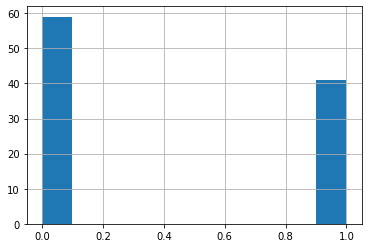

In [34]:
toy_data.SEX.hist()

<AxesSubplot:>

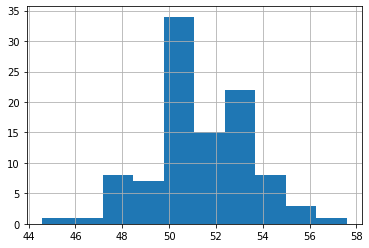

In [35]:
toy_data.AGE.hist()

<AxesSubplot:>

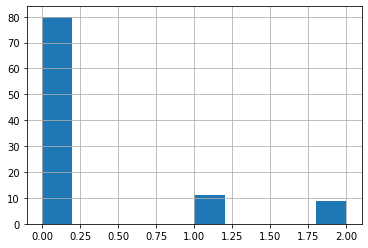

In [36]:
toy_data.CANCER_SEVERITY.hist()

<AxesSubplot:>

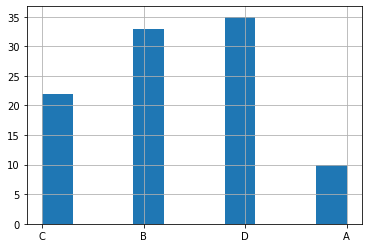

In [37]:
toy_data.MED_STATUS.hist()

TGAN - which is an article wrote for tabular data synthesis - writes that before they synthesized the dataset, scaling preprocessing was implemented. Thus, here we will apply preprocessing.

1. first we apply one hot encoding and scaling utility for Syndp

In [58]:
%%writefile ../syndp/utils/preprocessing.py

from sklearn.preprocessing import MinMaxScaler
import pandas as pd

def dummify(data : pd.DataFrame, columns= None, prefix_separator = "-"):
    '''
    dummifing function
    data : original data with categorical and continuous variables
    prefix_sep  mostly uses '_' as prefix separator. Can be modified
    columns : list of columns that are categorical
    '''
    excluded_variables = [continuous for continuous in data.columns if continuous not in columns]
    data1 = data[excluded_variables].copy() # we will concat this data with the dummified data
    
    list_of_series = [data[cols] for cols in columns]
    dummified = list(map(lambda x, y : pd.get_dummies(data=y, prefix=x, prefix_sep=prefix_separator), columns, list_of_series))
    
    dummified = pd.concat([data1, *dummified], axis=1)
    
    return dummified


def undummify(data :pd.DataFrame, columns :list, prefix_separator="-"):
    '''
    This function changes tabular data's categorical variable's one-hot dummy encoding to the original form
    data : original tabular data
    columns : a list of names of categorical values
    prefix_sep : prefix separator. Mostly is "-"
    '''
    # cols2collapse = {
    #     item.split(prefix_separator)[0]: (prefix_separator in item) for item in data.columns
    # }
    
    continuous_list = [cont for cont in data.columns if cont.split(prefix_separator)[0] not in columns]
    data1 = data[continuous_list].copy() # data to concat later

    undummified_list  = []
    for col in columns:
           undummified = data.filter(like=col).idxmax(axis=1).apply(lambda x : x.split(prefix_separator, maxsplit=1)[1]).rename(col)
       undummified_list.append(undummified) 
    
    recovered_data = pd.concat([data1, *undummified_list], axis=1)
    return recovered_data



def do_scaling(data : pd.DataFrame, columns : list):
    '''
    scaling function for continous variable. 
    This function returns the scaled data and the scaler itself for future use.
    data : the data you want to change
    columns : continuous columns
    '''
    scaler = MinMaxScaler(feature_range=(-1,1))
    not_scaling_columns = [cols for cols in data.columns if cols not in columns ]
    data1 = data[not_scaling_columns].copy()
    
    scaler.fit(data[columns].copy())
    scaled = scaler.transform(data[columns].copy())
    scaled= pd.DataFrame(scaled, columns=columns)
    
    scaled_data = pd.concat([scaled,data1], axis=1)
    return scaled_data, scaler
    


Overwriting ../syndp/utils/preprocessing.py


In [39]:
dummified_df = dummify(toy_data, columns=['SEX','MED_STATUS','CANCER_SEVERITY'], prefix_separator="-")

dummified_df.head()

,ID,AGE,HR,SEX-0,SEX-1,MED_STATUS-A,MED_STATUS-B,MED_STATUS-C,MED_STATUS-D,CANCER_SEVERITY-0,CANCER_SEVERITY-1,CANCER_SEVERITY-2
0,1,50.178607,100,1,0,0,0,1,0,0,0,1
1,2,53.038950,66,0,1,0,1,0,0,0,1,0
2,3,54.333601,97,1,0,0,0,0,1,1,0,0
3,4,50.226656,59,1,0,0,1,0,0,1,0,0
4,5,47.890375,77,1,0,0,0,1,0,0,1,0


In [40]:
undummify(dummified_df, columns=['SEX','MED_STATUS','CANCER_SEVERITY'], prefix_separator="-").head()

,ID,AGE,HR,SEX,MED_STATUS,CANCER_SEVERITY
0,1,50.178607,100,0,C,2
1,2,53.038950,66,1,B,1
2,3,54.333601,97,0,D,0
3,4,50.226656,59,0,B,0
4,5,47.890375,77,0,C,1


We made the dummifing function and recovering function. Now, we will make the scaling function

In [59]:
from sklearn.preprocessing import MinMaxScaler

def do_scaling(data : pd.DataFrame, columns : list):
    '''
    scaling function for continous variable. 
    This function returns the scaled data and the scaler itself for future use.
    data : the data you want to change
    columns : continuous columns
    '''
    scaler = MinMaxScaler(feature_range=(-1,1))
    not_scaling_columns = [cols for cols in data.columns if cols not in columns ]
    data1 = data[not_scaling_columns].copy()
    
    scaler.fit(data[columns].copy())
    scaled = scaler.transform(data[columns].copy())
    scaled= pd.DataFrame(scaled, columns=columns)
    
    scaled_data = pd.concat([scaled,data1], axis=1)
    return scaled_data, scaler
    


In [57]:
do_scaling(toy_data,['AGE',"HR"])

(         AGE        HR   ID  SEX  CANCER_SEVERITY MED_STATUS
 0  -0.138330  1.000000    1    0                2          C
 1   0.301870 -0.133333    2    1                1          B
 2   0.501114  0.900000    3    0                0          D
 3  -0.130935 -0.366667    4    0                0          B
 4  -0.490483  0.233333    5    0                1          C
 ..       ...       ...  ...  ...              ...        ...
 95  0.351642 -0.266667   96    0                1          A
 96  0.518384  0.166667   97    0                0          B
 97  0.253635 -0.433333   98    0                0          D
 98  0.470829 -0.833333   99    0                0          A
 99 -0.039829 -0.633333  100    0                0          D
 
 [100 rows x 6 columns],
 MinMaxScaler(feature_range=(-1, 1)))